# Part Three of the Course Project

Understanding the limitations of word vectors will help you build realistic and practical real-world models. In this project, you'll explore some functionality — and limitations — of word vectors via the Gensim library in the context of speeches given by various Presidents of the United States.

You'll define functions that will help you use NLP to build and examine document vectors. In particular, you will build a document vector for each speech (i.e., document) that will be the average of all word vectors you identify within the document. Then, you will identify words which are semantically close to the document vector and measure similarity among documents based on their vector representations. Finally, you will deduce that document vectors built from an averaged bag-of-word vectors lose their semantic representation as the size of the document increases. 
<hr style="border-top: 2px solid #606366; background: transparent;">

## Setup

Load and use Gensim's **glove-wiki-gigaword-50** model, which was described in the previous project assignment. This step may take 30 seconds.

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, numpy.testing as npt, nltk, gensim, matplotlib.pyplot as plt
from numpy.linalg import norm                           # Euclidean norm same as Euclidean distance from a vetor to coordinate origin
from scipy.spatial.distance import cosine, euclidean    # cosine distance (=1-cosine_similarity) and Euclidean distance
from sklearn.metrics.pairwise import cosine_similarity  # returns a symmetric matrix of cosine similarities for a list of vectors
from gensim.models import KeyedVectors                  # library to manipulate Gensim's word2vec and fastText models
import unittest
from colorunittest import run_unittest

_ = nltk.download(['punkt', 'inaugural'], quiet=True)   # downloading presidential inaugural speeches
LsFID = nltk.corpus.inaugural.fileids()                 # list of file IDs for presidential speeches
LsObamaWords = nltk.corpus.inaugural.words('2013-Obama.txt')    # list of words from Obama's speech in 2013
print(f'Versions. nltk:{nltk.__version__}, gensim:{gensim.__version__}, np:{np.__version__}')  # Codio: NLTK 3.6.2, gensim 4.0.1, np 1.19.5


# %time wv = KeyedVectors.load_word2vec_format("glove-wiki-gigaword-50.gz")
# sFile = 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz'
%time wv = KeyedVectors.load_word2vec_format('glove-wiki-gigaword-50.gz')  # load word2vec directly from URL
print(f'File IDs: {LsFID}')                             # print file IDs for all presidential speeches
wv['hello']  # print vector for the word

Versions. nltk:3.6.7, gensim:4.2.0, np:1.19.5
CPU times: user 41.8 s, sys: 627 ms, total: 42.4 s
Wall time: 42.7 s
File IDs: ['1789-Washington.txt', '1793-Washington.txt', '1797-Adams.txt', '1801-Jefferson.txt', '1805-Jefferson.txt', '1809-Madison.txt', '1813-Madison.txt', '1817-Monroe.txt', '1821-Monroe.txt', '1825-Adams.txt', '1829-Jackson.txt', '1833-Jackson.txt', '1837-VanBuren.txt', '1841-Harrison.txt', '1845-Polk.txt', '1849-Taylor.txt', '1853-Pierce.txt', '1857-Buchanan.txt', '1861-Lincoln.txt', '1865-Lincoln.txt', '1869-Grant.txt', '1873-Grant.txt', '1877-Hayes.txt', '1881-Garfield.txt', '1885-Cleveland.txt', '1889-Harrison.txt', '1893-Cleveland.txt', '1897-McKinley.txt', '1901-McKinley.txt', '1905-Roosevelt.txt', '1909-Taft.txt', '1913-Wilson.txt', '1917-Wilson.txt', '1921-Harding.txt', '1925-Coolidge.txt', '1929-Hoover.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt', '1949-Truman.txt', '1953-Eisenhower.txt', '1957-Eisenhower.txt', 

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ], dtype=float32)

# **Lowercased Vectorizable (LCV) Preprocessor**

In this task, you will create a preprocessing function that returns only the lowercased words that exist in `wv`'s library from a given list of words, `LsWords`. This output will be referred to as <b>LCV (lowercased vectorizable)</b> words. This function will help you avoid storage and processing of words not found in `wv`'s vocabulary. It will also help you avoid key errors, which arise whenever you try to draw a vector for a word that does not exist (as a key) in a `wv` dictionary.

<!--
For now, you will ignore the so-called "_combined words_", such as "new-york" and "commander-in-chief", which would require a more complex POS-based preprocessing, since these words are not identified in `nltk`'s corpora.
-->

In [2]:
def LCV(wv, LsWords=['NLP','is','fun','!']) -> [str]:
    ''' This is a small preprocessor to keep only 
        Lowercased Vectorizable (LCV) words from LsWords.
        Vectorizable are words that are found in wv's vocabulary,
        i.e. for which we can pull a meaningful word vector from the model
    wv: Gensim's word2vec model
    Return: a list of lower-cased tokens identified in wv   '''
    out = ['dummy']  # desired output format
    out = [word.lower() for word in LsWords if word.lower() in wv.key_to_index]
    return out

In [3]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_LCV(unittest.TestCase):
    def test_00(self):   
        npt.assert_equal(LCV(wv), ['nlp', 'is', 'fun', '!'])
    def test_01(self):   
        npt.assert_equal(LCV(wv, ['NLP','is_','fun_']), ['nlp'])
    def test_02(self):     
        npt.assert_equal(LCV(wv, ['NLP_','is_','fun_']), [])
    def test_03(self):   
        npt.assert_equal(LCV(wv, LsObamaWords)[:5], ['thank', 'you', '.', 'thank', 'you'])


Ran 4 tests in 0.007s

OK
test_00 (__main__.test_LCV) ... ok
test_01 (__main__.test_LCV) ... ok
test_02 (__main__.test_LCV) ... ok
test_03 (__main__.test_LCV) ... ok

----------------------------------------------------------------------



# **Document Vector**

In this task, you will write a function to calculate the [centroid](https://en.wikipedia.org/wiki/Centroid) of the vector embeddings for lowercased vectorizable (LCV) words in the given document.

This is an important task because, while a single word vector is useful, embedding the meaning of the whole text in a single numerical vector can help you compare document similarity. One simple way to do this is via arithmetic (element-wise) averaging (i.e., mean) of all LCV words from a document. This document vector would have exactly the same dimension as the dimensions of the vectors used to produce it. Here is a quick example with made-up 3-dimensional vectors.
 
Take the phrase "I like NLP_." Suppose after tokenization and conversion to lowercase, "nlp" is not in a Word2Vec model, but "i" and "like" have vector representations $[1,2]$ and $[1,4]$, respectively. The element-wise average would be computed as:
    
$$\left[\frac{1+1}{2},\frac{2+4}{2}\right]=[1,3]$$

The resulting document vector is $[1,3]$, which is also 2-dimensional. Element-wise average produces the <b>centroid</b>, which you will study at another time. A general formula for a centroid, given $p$-dimensional vectors $\mathbf{x}_1,...,\mathbf{x}_n$, is 

$$\mathbf{x}_{\text{centroid}}:=(\mathbf{x}_1+\cdots+\mathbf{x}_n)/n=\frac{1}{n}\sum_{i=1}^{n}\mathbf{x}_i$$

where $n\ge1$ is the number of word vectors from the given document and $p\ge1$ is the dimensionality of these word vectors. For example, the Gensim model has $p=50$ and the toy example above has $n=2$ (since one word dropped out due to absence of its vector in the Gensim's model).

<b>Note:</b> You will use all words in a document as a bag of words, without regard to their positioning, order, or distances to their neighboring words. This dramatically reduces the quality of the resulting document vector. However, the repetitive words can strongly influence the position of the document vector in the 50-dimensional vector space, so if the document discusses mostly cats and the other document discusses mostly dogs, then their vectors will represent cats and dogs, respectively.

In [4]:
def DV(wv, LsWords=['I','like','nlp']) -> np.array([]):
    '''Compute a document vector from the vectors of the LCV words in LsWord list.
        If none is found, return zero vector of the length of vectors in wv.
    wv: Gensim's word2vec model
    Return: a mean numpy array (a.k.a. centroid) based on element-wise 
        average of vectors representing words in LsWord  '''
    LCV_words = LCV(wv, LsWords)
    if not LCV_words:
        return np.zeros(wv.vector_size)
    word_vectors = np.array([wv[word] for word in LCV_words])
    return word_vectors.mean(axis=0)

In [5]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_DV(unittest.TestCase):
    def test_00(self):    
        npt.assert_equal(DV(wv, ['dr. strange']).sum(), 0.)
    def test_01(self):
        npt.assert_almost_equal(DV(wv, 'dr. strange').sum(), 2.0379, 4)
    def test_02(self):
        npt.assert_almost_equal(DV(wv, 'mad fox flew over the happy dog'.split()).sum(), -0.5092, 4)
    def test_03(self):
        npt.assert_almost_equal(DV(wv, ['Dr.', 'Strange'])[:5], [.4986, .4179, -.7995, .2013, .8009], 4)


Ran 4 tests in 0.002s

OK
test_00 (__main__.test_DV) ... ok
test_01 (__main__.test_DV) ... ok
test_02 (__main__.test_DV) ... ok
test_03 (__main__.test_DV) ... ok

----------------------------------------------------------------------



# **Words Most Similar to the Meaning of the Document**

In this task, you will build a function that returns the top 𝑛 words that have vectors most cosine-similar to the document vector. Doing this will help you determine which words in a particular document are most representative of that document. 

For this, you would need to compute cosine similarity for every pair of (LCV word vector, document vector) and pick those that have the highest cosine similarity.

**Note**: The representative vector is unlikely to be some word within the vocabulary (aka a **medoid**, which we will learn more about in the next course), unless the document vector was aggregated from the same repeated word from the vocabulary. For example, a document vector built from "cat cat cat" will be exactly the same as the word vector for "cat," but a document built from "cats and dogs" will not equal any of the vectors in the Word2Vec model (due to continuity of real numbers). Despite this, you should still hope to find a word that has a vector very close to the document.

In [6]:
from scipy.spatial.distance import cosine

def TopWords(wv, LsWords=['super', 'cow', 'now'], n=1):
    ''' Retrieve top n unique LCV words from LsWords ordered by their cosine-similarity 
          to the document vector based on LCV LsWords. Use DV() to compute a document vector.
          Hint: applying set() removes duplicates
    wv: Gensim's word2vec model
    Return: list of tuples (word from LsWords, cosine similarity(X,DV(LsWords)) ) 
        ordered by decreasing similarity. If none is found return None   '''
    doc_vector = DV(wv, LsWords)
    LCV_words = list(set(LCV(wv, LsWords)))
    if not LCV_words:
        return None
    word_similarities = []
    for word in LCV_words:
        word_vector = wv[word]
        sim = 1 - cosine(doc_vector, word_vector)
        word_similarities.append((word, sim))
    word_similarities = sorted(word_similarities, key=lambda x: x[1], reverse=True)
#     print("Cosine Similarities:")
#     for word, sim in word_similarities:
#         print(f"Word: {word}, Cosine Similarity: {sim}")
    return word_similarities[:n]


In [7]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_TopWords(unittest.TestCase):
    def test_00(self):    
        npt.assert_equal(TopWords(wv)[0][0], 'now')
    def test_01(self):
        npt.assert_almost_equal(TopWords(wv)[0][1], 0.8046, 4)
    def test_02(self):
        npt.assert_equal(TopWords(wv, ['cat_']), None)
    def test_03(self):
        LTsnTop = TopWords(wv, ['the','cat','dog','tiger','lion'], n=2)
        npt.assert_equal([w for w,_ in LTsnTop], ['cat','dog'])         # test word near the document vector
    def test_04(self):
        LTsnTop = TopWords(wv, ['the','cat','dog','tiger','lion'], n=2)
        npt.assert_almost_equal([sim for _,sim in LTsnTop], [.8886,.8857], 4)   # test similarity metrics
    def test_05(self):
        npt.assert_equal(TopWords(wv, 'the cat , the dog and the ant '.split())[0][0], 'the')   # repeated word dominates the document vector
    def test_06(self):
        npt.assert_almost_equal(TopWords(wv, 'mad fox flew over the happy dog'.split())[0][1], 0.8182, 4)
    def test_07(self):
        npt.assert_equal([w for w,_ in TopWords(wv, LsObamaWords, 5)], ['.', 'but', 'well', 'to', 'same'])


Ran 8 tests in 0.086s

OK
test_00 (__main__.test_TopWords) ... ok
test_01 (__main__.test_TopWords) ... ok
test_02 (__main__.test_TopWords) ... ok
test_03 (__main__.test_TopWords) ... ok
test_04 (__main__.test_TopWords) ... ok
test_05 (__main__.test_TopWords) ... ok
test_06 (__main__.test_TopWords) ... ok
test_07 (__main__.test_TopWords) ... ok

----------------------------------------------------------------------



# **Nearest Neighbor to the Origin**

In this task, you will define a function that uses a different metric to find a vector most similar to the origin, $\mathbf{0}^T:=[0,0,...,0]$ vector, where $\mathbf{0}^T$ is the transpose of the vector $\mathbf{0}$. Instead of cosine similarity, use Euclidean distance to find the nearest neighbor of a zero vector. That is, given word $[w_i]_{i=1}^p$ and Word2Vec vector function $\mathbf{v}(w_i)\in\mathbb{R}^{50}$, find the word corresponding to the smallest norm of its vector:
$$w^*:=\text{argmin}_{w_i} ||\mathbf{v}(w_i)-\mathbf{0}||_2=\text{argmin}_{w_i} ||\mathbf{v}(w_i)||_2$$

<b>Note:</b> Formally, all vectors are column vectors unless noted otherwise. The distance of any vector to the origin is just the norm of that vector. 

In [8]:
def NN0(wv, LsWords=['Cat', 'in', 'the', 'hat']) -> (str, float):
    ''' Among LCV words in LsWords find the one nearest 
        to the origin vector (a.k.a. zero vector).
    wv: Gensim's word2vec model
    Return: tuple (word from LsWord, its norm) in decreasing order of norm.
        If none is found, return None. '''
    LCV_words = LCV(wv, LsWords)
    if not LCV_words:
        return None
    word_norms = []
    for word in LCV_words:
        word_vector = wv[word]
        norm = np.linalg.norm(word_vector)
        word_norms.append((word, norm))
    word_norms = sorted(word_norms, key=lambda x: x[1])
    return word_norms[0] if word_norms else None

In [9]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_NN0(unittest.TestCase):
    def test_00(self):   
        npt.assert_equal(NN0(wv, ['deep_','learning_']), None)
    def test_01(self): 
        npt.assert_equal(NN0(wv, ['a','the','and'])[0], 'and')
    def test_02(self): 
        npt.assert_equal(NN0(wv, wv.index_to_key[:1000])[0], 'brought')
    def test_03(self): 
        npt.assert_equal(NN0(wv, wv.index_to_key[:10000])[0], 'likewise')


Ran 4 tests in 0.153s

OK
test_00 (__main__.test_NN0) ... ok
test_01 (__main__.test_NN0) ... ok
test_02 (__main__.test_NN0) ... ok
test_03 (__main__.test_NN0) ... ok

----------------------------------------------------------------------



# **Nearest Presidential Speech**

In this task, you will convert several presidential speech documents to document vectors and find the most similar speech given a particular presidential speech.

You would expect that vectors of the Obama speeches would be closer to each other than to the document vectors of other presidents, but it turns out to be not the case. One cause is that the vectors and the model are too simple to capture the language complexity for larger documents. Another problem is that averaging entire documents makes all documents alike because there are many more "generic" words in each speech than specific words identifying the specific president. Note that the phrases, complex expressions, and sequential ordering of the words in the speech (which would be exceptionally helpful in better capturing the semantics of a document) are ignored.


In [10]:
def is_valid_fid(fid):
    try:
        find(f"corpora/inaugural/{fid}")
        return True
    except LookupError:
        return False

def NN_Pres(wv, sQryFID='1945-Roosevelt.txt', LvCorpusFID=['1865-Lincoln.txt', '1905-Roosevelt.txt']) -> (str, float):
    ''' For each file id (FID) in LvCorpusFID of presidential inaugural speeches,
          compute a document vector using DV() function and identify FID closest to the vector of 
          query speech in sQryFID. If sQryFID appears in LvCorpusFID, drop it from the list.
    wv: Gensim's word2vec model
    Return: tuple (file id, cosine similarity) or None if valid results cannot be produced '''
    out = ('dummy', 0.0)  # Default output value
    if not is_valid_fid(sQryFID):
        return None
    if sQryFID in LvCorpusFID:
        LvCorpusFID.remove(sQryFID)
    LvCorpusFID = [fid for fid in LvCorpusFID if is_valid_fid(fid)]
    if not LvCorpusFID:
        return None
    query_words = nltk.corpus.inaugural.words(sQryFID)
    query_vector = DV(wv, query_words)
    if query_vector is None or np.all(query_vector == 0):
        return None
    max_similarity = -1
    best_fid = None
    for fid in LvCorpusFID:
        corpus_words = nltk.corpus.inaugural.words(fid)
        corpus_vector = DV(wv, corpus_words)
        if corpus_vector is None or np.all(corpus_vector == 0):
            continue
        similarity = 1 - cosine(query_vector, corpus_vector)
        if similarity > max_similarity:
            max_similarity = similarity
            best_fid = fid
    if best_fid is not None:
        out = (best_fid, max_similarity)
    return out


In [11]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_NN_Pres(unittest.TestCase):
    def test_00(self):  
        npt.assert_equal(NN_Pres(wv, 'bad_FID'), None)
    def test_01(self): 
        npt.assert_equal(NN_Pres(wv, '1945-Roosevelt.txt', ['bad_FID']), None)

    def test_02(self): 
        npt.assert_equal(NN_Pres(wv)[0], '1905-Roosevelt.txt')
    def test_03(self): 
        npt.assert_equal(NN_Pres(wv, '1961-Kennedy.txt', LsFID)[0], '1973-Nixon.txt')
    def test_04(self): 
        npt.assert_equal(NN_Pres(wv, '2013-Obama.txt', LsFID)[0], '1977-Carter.txt')

    def test_05(self): 
        npt.assert_almost_equal(NN_Pres(wv)[1], 0.9973, 4)
    def test_06(self): 
        npt.assert_almost_equal(NN_Pres(wv, '1961-Kennedy.txt', LsFID)[1], .999, 4)
    def test_07(self): 
        npt.assert_almost_equal(NN_Pres(wv, '2013-Obama.txt', LsFID)[1], .9993, 4)


Ran 8 tests in 0.001s

FAILED (errors=8)
test_00 (__main__.test_NN_Pres) ... ERROR
test_01 (__main__.test_NN_Pres) ... ERROR
test_02 (__main__.test_NN_Pres) ... ERROR
test_03 (__main__.test_NN_Pres) ... ERROR
test_04 (__main__.test_NN_Pres) ... ERROR
test_05 (__main__.test_NN_Pres) ... ERROR
test_06 (__main__.test_NN_Pres) ... ERROR
test_07 (__main__.test_NN_Pres) ... ERROR

ERROR: test_00 (__main__.test_NN_Pres)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-11-0789930e1123>", line 5, in test_00
    npt.assert_equal(NN_Pres(wv, 'bad_FID'), None)
  File "<ipython-input-10-8fb40bfae0f7>", line 15, in NN_Pres
    if not is_valid_fid(sQryFID):
  File "<ipython-input-10-8fb40bfae0f7>", line 3, in is_valid_fid
    find(f"corpora/inaugural/{fid}")
NameError: name 'find' is not defined

ERROR: test_01 (__main__.test_NN_Pres)
----------------------------------------------------------------------
Traceback (most r

# **Cumulative Mean**

Next, you will visualize the averaging effect on the elements of the document vector by completing the following UDF, `CumMean`. First, compute a cumulative mean of the given input vector, `x`. Recall that the cumulative mean is simply the mean of all points in the dataset.

In [12]:
def CumMean(x=np.array([0,1,2])) -> np.array([float]):
    ''' For the 1D array x, return an array y that is a cumulative mean of elements of x. 
      Hint: you can use np.cumsum() function and scale each element by its index,
      which starts with 1 and ends with a length of x.
      Length of y is the same as length of x and their first elements are equal.
      wv: Gensim's word2vec model  '''
    if len(x) == 0:
        return np.array([])
    y = np.cumsum(x)
    return y / (np.arange(1, len(x) + 1))

In [13]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_CumMean(unittest.TestCase):
    def test_00(self):  
        npt.assert_equal(CumMean([]), np.array([]))
    def test_01(self):  
        npt.assert_equal(CumMean([0,1,2]), np.array([0., 0.5, 1.]))
    def test_02(self):  
        npt.assert_equal(CumMean([0,1,2,3]), np.array([0., 0.5, 1., 1.5]))
    def test_03(self):  
        npt.assert_equal(CumMean([0,1,2,3,4]), np.array([0., 0.5, 1., 1.5, 2.]))
    def test_04(self):  
        npt.assert_almost_equal(CumMean(wv['hi'][:6]), np.array([-0.543 , -0.099 ,  0.024 ,  0.281, -0.009, -0.219]), 3)


Ran 5 tests in 0.001s

OK
test_00 (__main__.test_CumMean) ... ok
test_01 (__main__.test_CumMean) ... ok
test_02 (__main__.test_CumMean) ... ok
test_03 (__main__.test_CumMean) ... ok
test_04 (__main__.test_CumMean) ... ok

----------------------------------------------------------------------



# **Pick Positional Value**

Next, you will draw the vector value from a specified position, `nPos`, for each word in the document, `LsWords`. This will allow you to build a visualization for changes in means of just one real value in the specified position of a document vector in a 2D plot. In other words, you will focus on working with and understanding just one value in a vector, rather than all values in a vector.

In [14]:
def PickPosValues(wv, LsWords=['NLP', 'is'], nPos=0) -> [float]:
    ''' Retrieve word vectors for each word in LsWords.
        Then extract the value at nPos position from each vector.
    wv: Gensim's word2vec model
    Return: a list of numeric values from nPos positions of word vectors 
        or [] if no words are found '''
    out = []  # Initialize output list
    for word in LsWords:
        normalized_word = word.lower()
        if normalized_word in wv:
            vector = wv[normalized_word]
            if 0 <= nPos < len(vector):
                out.append(float(vector[nPos]))
#             else:
#                 print(f"Warning: nPos {nPos} is out of bounds for word '{word}'")
#         else:
#             print(f"Warning: '{word}' not found in vocabulary.")
    return out

In [15]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_PickPosValues(unittest.TestCase):
    def test_00(self):
        npt.assert_equal(PickPosValues(wv, ['nlp_']), [])
    def test_01(self):
        npt.assert_almost_equal(PickPosValues(wv, ['NLP']), [-.6721], 3)
    def test_02(self):
        npt.assert_almost_equal(PickPosValues(wv, ['NLP','is']), [-.672,  .619], 3)
    def test_03(self):
        npt.assert_almost_equal(PickPosValues(wv, ['NLP','is', 'fun']), [-.672, .619, -.238], 3)
    def test_04(self):
        npt.assert_almost_equal(PickPosValues(wv, ['NLP','is', 'fun', '!']), [-.672,  .619, -.238, -.584], 3)
    def test_05(self):
        npt.assert_almost_equal(sum(PickPosValues(wv, LsObamaWords[:10])), 0.5302, 4)
    def test_06(self):
        npt.assert_almost_equal(sum(PickPosValues(wv, LsObamaWords)), 688.3026, 4)
        

Ran 7 tests in 0.015s

OK
test_00 (__main__.test_PickPosValues) ... ok
test_01 (__main__.test_PickPosValues) ... ok
test_02 (__main__.test_PickPosValues) ... ok
test_03 (__main__.test_PickPosValues) ... ok
test_04 (__main__.test_PickPosValues) ... ok
test_05 (__main__.test_PickPosValues) ... ok
test_06 (__main__.test_PickPosValues) ... ok

----------------------------------------------------------------------



# **Cumulative Mean in Position**
 
Finally, you will combine the previous two UDFs to retrieve the cumulative mean at a specific position of the document vector. To do so, apply `PickPosValues()` to `LsWords` and then apply `CumMean()` to the output. The first few values will vary markedly, but the cumulative mean quickly stabilizes at approximately the same value across all lengthy documents. This stabilization confirms that vector averaging is suitable for short documents and phrases with few stopwords.

In [16]:
import numpy as np

def CumMeanInPos(wv, LsWords=['Hi', 'from', 'Mars', '!'], nPos=0, nSkip=50) -> np.array:
    '''Compute cumulative mean of the value in the nPos position of the
       word vectors of LCV words in LsWords. Use PickPosValues() and CumMean().
       Drop the first nSkip values before returning the result.'''
    pos_values = PickPosValues(wv, LsWords, nPos)
    cumulative_mean = CumMean(np.array(pos_values))
    if len(cumulative_mean) > nSkip:
        return cumulative_mean[nSkip:]
    else:
        return np.array([])

In [17]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_CumMeanInPos(unittest.TestCase):
    def test_00(self):
        npt.assert_equal(CumMeanInPos(wv, ['']), np.array([]))
    def test_01(self):
        npt.assert_equal(CumMeanInPos(wv, nPos=0, nSkip=10), np.array([]))
    def test_02(self):
        npt.assert_almost_equal(CumMeanInPos(wv, nPos=1, nSkip=0), np.array([.344, .229, .457, .44]), 3)
    def test_03(self):
        npt.assert_almost_equal(CumMeanInPos(wv, nPos=2, nSkip=2), np.array([.297, .386]), 3)
    def test_04(self):
        npt.assert_almost_equal(CumMeanInPos(wv, LsObamaWords, nPos=0, nSkip=1)[:5], np.array([-.041, .023, -.003, -.002, .099]), 3)
    def test_05(self):
        npt.assert_almost_equal(CumMeanInPos(wv, LsObamaWords)[-9:], np.array([0.294]*9), 3)  # final cumulative mean values are nearly cosntant
    def test_06(self):
        npt.assert_almost_equal(CumMeanInPos(wv, LsObamaWords).sum(), 662.88, 3)


Ran 7 tests in 0.046s

OK
test_00 (__main__.test_CumMeanInPos) ... ok
test_01 (__main__.test_CumMeanInPos) ... ok
test_02 (__main__.test_CumMeanInPos) ... ok
test_03 (__main__.test_CumMeanInPos) ... ok
test_04 (__main__.test_CumMeanInPos) ... ok
test_05 (__main__.test_CumMeanInPos) ... ok
test_06 (__main__.test_CumMeanInPos) ... ok

----------------------------------------------------------------------



# **Visualization of Cumulative Means**

Run the following code to create a visualization of the cumulative mean for several presidential speeches. Examine the plot, noticing the variability of the cumulative means for the shorter excerpts from speeches compared to those with more words. If you try a different value position in a cumulative mean vector, the cumulative mean will stabilize at a different value, but the overall pattern of the plot will be similar, i.e., volatile initially for the first few hundred words. So, document vectors from large documents tend to converge.

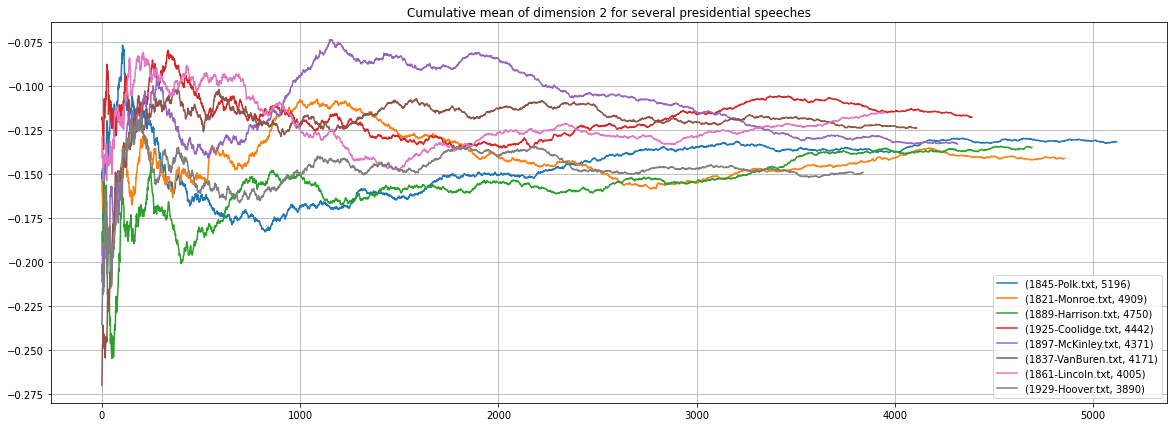

In [18]:
nDim = 2
LTsLongestSpeeches = sorted([(fid, len(nltk.corpus.inaugural.words(fid))) for fid in LsFID], key=lambda x: -x[1])[2:10]
LvCumMean = [CumMeanInPos(wv, nltk.corpus.inaugural.words(fid), nDim) for fid, _ in LTsLongestSpeeches]
sTitle = f'Cumulative mean of dimension {nDim} for several presidential speeches'
pd.DataFrame(LvCumMean, index=LTsLongestSpeeches).T.plot(figsize=(20,7), grid=True, title=sTitle);